In [1]:
from Util import *

In [35]:
try:
    with open("pos.dat", "rb") as f:
        X, y = pickle.load(f)
except FileNotFoundError:
    with open("ball_markup.json", "r") as f:
        data: dict = json.load(f)
    W, H = SIZE = (160, 90)
    X, y = [], []
    N = 2000

    cam = cv2.VideoCapture("game_1.mp4")
    for key, value in tqdm(random.sample(list(data.items()), N)):
        cam.set(cv2.CAP_PROP_POS_FRAMES, int(key))
        _, img = cam.read()
        h, w, c = img.shape
        img = cv2.resize(img, SIZE)
        X.append(cv2.split(img))
        v = [value['x']*W//w, value['y']*H//h]
        y.append(v)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    cam.release()
    with open("pos.dat", "wb") as f:
        pickle.dump((X, y), f)
train_X, val_X, test_X, train_y, val_y, test_y = preprocess(X, y)


In [36]:
def get_output_size(w, k, p, s):
    return (w-k+2*p)//s + 1
w = get_output_size(160, 5, 0, 2)
h = get_output_size(90, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
print(w*h*12)

168


In [37]:
net = load("posnet.dat", NN([3, 6, 9, 12, 12], [288, 2]))

NameError: name 'load' is not defined

 10%|█         | 1040/10000 [01:59<17:05,  8.74it/s]


Stopped at Epoch 1040
Loss: 274.16058349609375


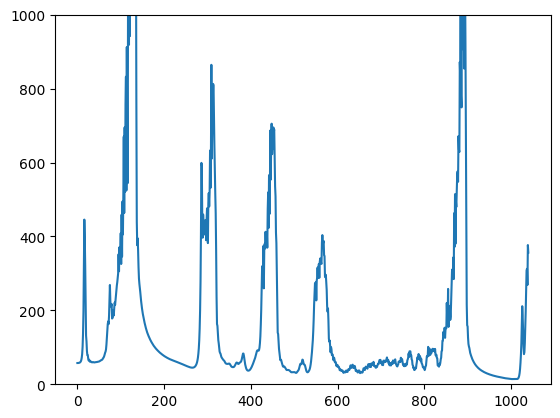

In [ ]:
net.my_train(train_X, train_y, val_X, val_y, 10000)
with open("posnet.dat", "wb") as f:
    pickle.dump(net, f)

In [ ]:
with open("posnet.dat", "rb") as f:
    net = pickle.load(f)
for x, y in zip(test_X, test_y):
    r, g, b = x.cpu().numpy().astype(np.uint8)
    img = cv2.merge([r, g, b])
    h, w, c = img.shape
    img = cv2.resize(img, (1200, 900))
    c = net(x.unsqueeze(0))[0]
    c = (int(c[0]*1200/w), int(c[1]*900/h))
    img = cv2.circle(img, c, 10, (0, 0, 255))
    c = (int(y[0]*1200/w), int(y[1]*900/h))
    img = cv2.circle(img, c, 20, (0, 255, 0))

    cv2.destroyAllWindows()
    # break


In [2]:
try:
    with open("exist.dat", "rb") as f:
        X, y = pickle.load(f)
except FileNotFoundError:
    with open("ball_markup.json", "r") as f:
        data: dict = json.load(f)
    W, H = SIZE = (100, 200)
    MARGIN = 1/50
    X, y = [], []
    N = 100
    cam = cv2.VideoCapture("game_1.mp4")
    frame_count = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
    _, img = cam.read()
    h, w, c = img.shape
    mid = w/2
    low, high = int(mid-w*MARGIN), int(mid+w*MARGIN)
    count = 0
    pos = set(int(i) for i in filter(lambda x: low<=int(data[x]["x"])<=high, data.keys()))
    l = list(range(frame_count))
    random.shuffle(l)
    for frame in pos:
        cam.set(cv2.CAP_PROP_POS_FRAMES, frame)
        _, img = cam.read()
        h, w, c = img.shape
        img = img[0:h*2//3, low:high]
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_LINEAR)
        
        X.append(cv2.split(img))
        y.append([1, 0])
    for frame in l:
        if frame in pos:
            continue
        count+=1
        cam.set(cv2.CAP_PROP_POS_FRAMES, frame)
        _, img = cam.read()
        h, w, c = img.shape
        img = img[0:h*2//3, low:high]
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_LINEAR)
        X.append(cv2.split(img))
        y.append([0, 1])
        if count >= len(pos): break
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    cam.release()
    with open("exist.dat", "wb") as f:
        pickle.dump((X, y), f)
train_X, val_X, test_X, train_y, val_y, test_y = preprocess(X, y)

In [3]:
net2 = load("existnet.dat", NN2([3, 6, 9, 9, 12], [480, 2]))


 56%|█████▌    | 2800/5000 [04:49<03:47,  9.66it/s]


Stopped at Epoch 2800
Loss: 1.0382757186889648


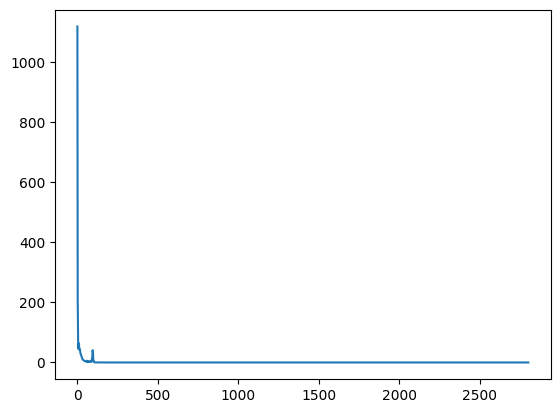

In [4]:
net2.my_train(train_X, train_y, val_X, val_y, 5000)
with open("existnet.dat", "wb") as f:
    pickle.dump(net2, f)

In [5]:
print(net2.ratio(test_X, test_y))

tensor([1.0000e+00, 5.9722e-19], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1.0000e+00, 2.2535e-20], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([9.5989e-43, 1.0000e+00], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([0., 1.], device='cuda:0')
tensor([1.0000e+00, 3.8497e-26], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([2.6792e-20, 1.0000e+00], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([0., 1.], device='cuda:0')
tensor([1.0000e+00, 1.0682e-40], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1.8371e-16, 1.0000e+00], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([0., 1.], device='cuda:0')
tensor([1.0000e+00, 1.9934e-08], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([0., 1.], device='cuda:0')
tensor([5.3091e-1